In [59]:
import os
import sys
import itertools

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [61]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [62]:
MAIN_DIR=os.getcwd()
DATA_DIR=os.path.join(MAIN_DIR,'data')
R_DATA_DIR=os.path.join(DATA_DIR,'raw_data')
N_DATA_DIR=os.path.join(DATA_DIR,'clean_data')

print(MAIN_DIR)
print(DATA_DIR)
print(R_DATA_DIR)
print(N_DATA_DIR)

/mnt/c/workspace/gametheory_oil_market
/mnt/c/workspace/gametheory_oil_market/data
/mnt/c/workspace/gametheory_oil_market/data/raw_data
/mnt/c/workspace/gametheory_oil_market/data/clean_data


In [74]:
crude_price_m = pd.read_csv(os.path.join(N_DATA_DIR,'crude_price_m.csv'), index_col=0)
g20_cli_m = pd.read_csv(os.path.join(N_DATA_DIR,'g20_cli_m.csv'), index_col=0)
crude_price_y = pd.read_csv(os.path.join(N_DATA_DIR,'crude_price_y.csv'), index_col=0)
crude_production_y = pd.read_csv(os.path.join(N_DATA_DIR,'crude_production_y.csv'), index_col=0)
g20_cli_y = pd.read_csv(os.path.join(N_DATA_DIR,'g20_cli_y.csv'), index_col=0)

In [75]:
def plot_order_acf(data):

    f=plt.figure(figsize=(10,15))
    
    ax1_1=f.add_subplot(421)
    ax1_1.set_title('zero order differencing')
    ax1_1.plot(data.values)

    ax1_2=f.add_subplot(422)
    plot_acf(data, ax=ax1_2)
    

    ax2_1=f.add_subplot(423)
    ax2_1.set_title('1st order differencing')
    ax2_1.plot(data.diff().values)

    ax2_2=f.add_subplot(424)
    plot_pacf(data.diff().dropna(), ax=ax2_2)


    ax3_1=f.add_subplot(425)
    ax3_1.set_title('2nd order differencing')
    ax3_1.plot(data.diff().diff().values)

    ax3_2=f.add_subplot(426)
    plot_pacf(data.diff().diff().dropna(), ax=ax3_2)

    ax4_1=f.add_subplot(427)
    ax4_1.set_title('3rd order differencing')
    ax4_1.plot(data.diff().diff().diff().values)

    ax4_2=f.add_subplot(428)
    plot_pacf(data.diff().diff().diff().dropna(), ax=ax4_2)
    plt.show()

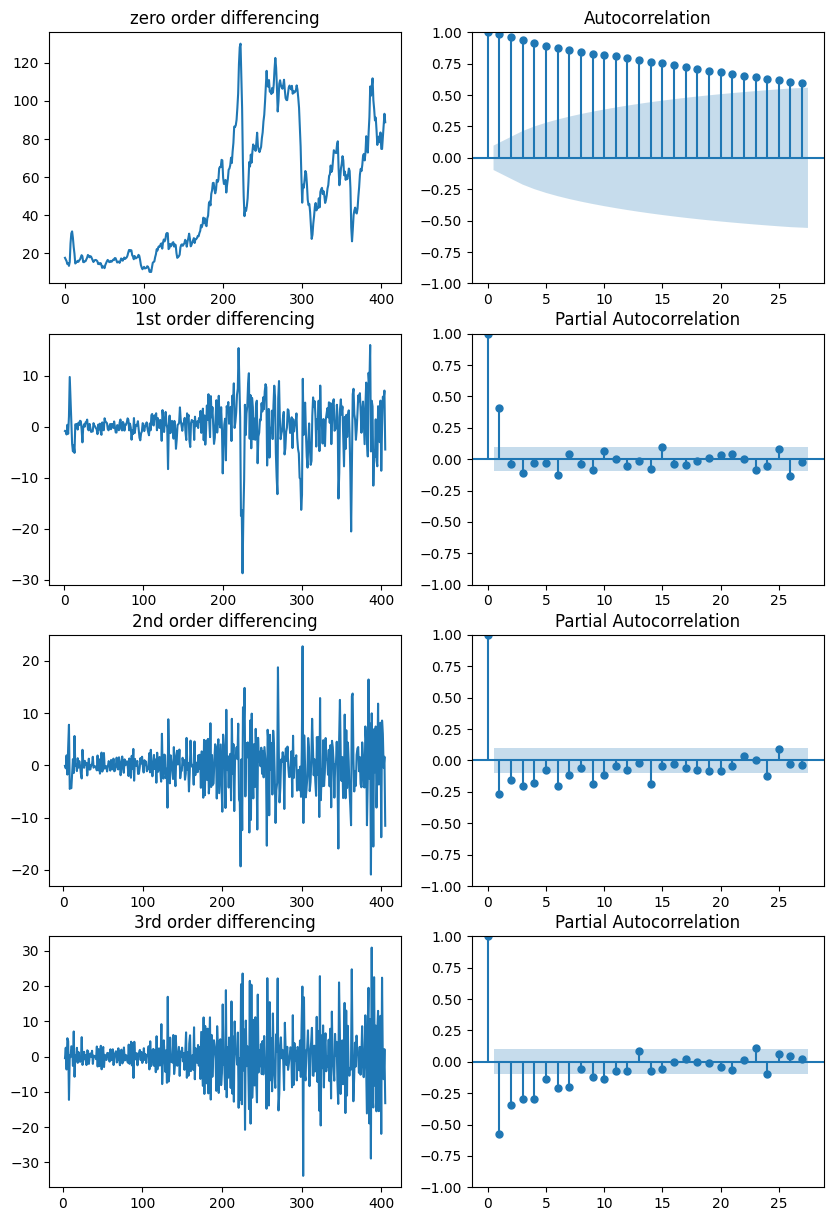

In [76]:
plot_order_acf(crude_price_m)

In [77]:
def calc_p_value_adf(data, threshold=0.05):
    # threshold=0.05

    result=adfuller(data)
    _0_result=result[1]
    print('p-value 0 order diff', result[1])

    result=adfuller(data.diff().dropna())
    _1_result=result[1]
    print('p-value 1 order diff', result[1])

    result=adfuller(data.diff().diff().dropna())
    _2_result=result[1]
    print('p-value 2 order diff', result[1])

    result=adfuller(data.diff().diff().diff().dropna())
    _3_result=result[1]
    print('p-value 3 order diff', result[1])

    if _0_result < threshold:
        print("0 order satisfy the criteria")
    elif _1_result < threshold:
        print("1 order satisfy the criteria")
    elif _2_result < threshold:
        print("2 order satisfy the criteria")
    elif _3_result < threshold:
        print("3 order satisfy the criteria")
    else:
        print("0 ~ 3 order does not satisfy ACF condition")

In [78]:
calc_p_value_adf(crude_price_m)

p-value 0 order diff 0.1882124291740272
p-value 1 order diff 1.0811777341588914e-15
p-value 2 order diff 8.715255027258941e-17
p-value 3 order diff 2.4303851702502524e-18
1 order satisfy the criteria


In [79]:
def AIC_PDQS(df):

    '''
    Runs grid search to return lowest AIC result for permutations of pdq/s values in range 0,2
    df - Dataframe to analyze for best pdq/s permutation
    '''

    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Auto-Regressive (p) -> Number of autoregressive terms.
    # Integrated (d) -> Number of nonseasonal differences needed for stationarity.
    # Moving Average (q) -> Number of lagged forecast errors in the prediction equation.

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    # Run a grid with pdq and seasonal pdq parameters calculated above and get #the best AIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            print(comb, combs)
            try:
                mod = sm.tsa.statespace.SARIMAX(df,order=comb,seasonal_order=combs,
                enforce_stationarity=False,enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                print('exception')
                continue


    # Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    print(ans_df.loc[ans_df['aic'].idxmin()])
    return ans_df

In [80]:
AIC_PDQS(crude_price_m)

(0, 0, 0) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.48780D+00    |proj g|=  3.79552D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   1.963D-08   5.488D+00
  F =   5.4877989465930064     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4458.092744633521
(0, 0, 0) (0, 0, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 


At iterate    5    f=  5.07168D+00    |proj g|=  9.83685D-03

At iterate   10    f=  5.06127D+00    |proj g|=  2.15611D-01


/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst


At iterate   15    f=  4.89853D+00    |proj g|=  7.38915D-03

At iterate   20    f=  4.89761D+00    |proj g|=  1.60032D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     22      1     0     0   1.600D-06   4.898D+00
  F =   4.8976098930794230     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =3980.859233180491
(0, 0, 0) (0, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25009D+00   

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     12      1     0     0   8.740D-08   4.116D+00
  F =   4.1161375630122556     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =3346.3037011659517
(0, 0, 0) (1, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25609D+00    |proj g|=  4.38121D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information w


At iterate   10    f=  4.23442D+00    |proj g|=  3.57101D-02

At iterate   15    f=  4.23326D+00    |proj g|=  1.68541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   9.019D-05   4.233D+00
  F =   4.2332620375211771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =3443.408774467196
(0, 0, 0) (1, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13175D+00   

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst


At iterate    5    f=  4.11975D+00    |proj g|=  7.44491D-02

At iterate   10    f=  4.11287D+00    |proj g|=  5.19294D-03

At iterate   15    f=  4.11200D+00    |proj g|=  1.05072D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   1.358D-06   4.112D+00
  F =   4.1120039781401996     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =3344.947230249842
(0, 0, 1) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables ar

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst


At iterate    5    f=  4.89269D+00    |proj g|=  4.28101D-02

At iterate   10    f=  4.86324D+00    |proj g|=  1.29051D-01

At iterate   15    f=  4.30797D+00    |proj g|=  2.61917D-01

At iterate   20    f=  4.26858D+00    |proj g|=  5.02387D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     34      1     0     0   1.652D-05   4.269D+00
  F =   4.2685725566251822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =3472.080915979648
(0, 0, 1) (0, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =  

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst


At iterate   10    f=  3.70873D+00    |proj g|=  1.76859D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     26      1     0     0   1.622D-05   3.709D+00
  F =   3.7086769343989987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =3015.445670731987
(0, 0, 1) (0, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96049D+00    |proj g|=  5.71873D-01

At iterate    5    f=  3.73552D+00   

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


  ys=-1.594E-01  -gs= 6.209E-01 BFGS update SKIPPED

At iterate   10    f=  3.75274D+00    |proj g|=  1.27306D-01

At iterate   15    f=  3.72024D+00    |proj g|=  3.31113D-02

At iterate   20    f=  3.71992D+00    |proj g|=  3.40696D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     47      1     1     0   3.407D-06   3.720D+00
  F =   3.7199239659662133     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =3026.5782603645653
(0, 0, 1) (1, 0, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           

 This problem is unconstrained.



At iterate   10    f=  4.78734D+00    |proj g|=  1.28921D-01

At iterate   15    f=  4.08180D+00    |proj g|=  6.31367D-01

At iterate   20    f=  3.70119D+00    |proj g|=  3.98992D-02

At iterate   25    f=  3.68872D+00    |proj g|=  3.02700D-02

At iterate   30    f=  3.68716D+00    |proj g|=  9.22943D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     55      1     0     0   1.584D-05   3.687D+00
  F =   3.6871358923366433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =3001.9543445773543
(0, 0, 1) (1, 1, 0, 12)
RUNNING THE L-BFGS

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  3.61277D+00    |proj g|=  1.04996D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   1.687D-05   3.613D+00
  F =   3.6127682234954883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =2939.5677974783366
(0, 0, 1) (1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96171D+00    |proj g|=  5.70498D-01


/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.74418D+00    |proj g|=  3.35237D-02

At iterate   10    f=  3.59311D+00    |proj g|=  1.05578D-01

At iterate   15    f=  3.57968D+00    |proj g|=  9.54407D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   1.698D-06   3.580D+00
  F =   3.5795943834054231     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =2914.6306393252034
(0, 1, 0) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables a

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86538D+00    |proj g|=  1.16731D-02

At iterate    5    f=  2.86448D+00    |proj g|=  1.35922D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   1.359D-06   2.864D+00
  F =   2.8644812211635062     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =2329.958751584767
(0, 1, 0) (0, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00846D+00    |proj g|=  5.40061D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.401D-06   3.008D+00
  F =   3.0084590025797451     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =2446.868710094753
(0, 1, 0) (1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst


At iterate    5    f=  2.78473D+00    |proj g|=  1.61068D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   9.445D-06   2.785D+00
  F =   2.7847292918518542     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =2267.2001849837056
(0, 1, 1) (0, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11496D+00    |proj g|=  1.30099D-01

At iterate    5    f=  3.11009D+00  

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.77787D+00    |proj g|=  5.18740D-02

At iterate   10    f=  2.74604D+00    |proj g|=  2.15627D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   4.718D-06   2.746D+00
  F =   2.7460368499108019     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =2235.7819221275713
(0, 1, 1) (1, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80184D+00  

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst


At iterate   10    f=  2.78465D+00    |proj g|=  4.85541D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   8.371D-06   2.785D+00
  F =   2.7846464871533017     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =2269.132947568481
(0, 1, 1) (1, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95294D+00    |proj g|=  1.02051D-01

At iterate    5    f=  2.94197D+00   

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86654D+00    |proj g|=  1.40753D-01

At iterate    5    f=  2.78048D+00    |proj g|=  1.00850D-01

At iterate   10    f=  2.74614D+00    |proj g|=  1.26417D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     28      1     0     0   1.177D-04   2.746D+00
  F =   2.7460361167389840     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =2237.781326792055


/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information w


At iterate   10    f=  3.05560D+00    |proj g|=  4.26992D-01

At iterate   15    f=  2.92648D+00    |proj g|=  2.77780D-01

At iterate   20    f=  2.88778D+00    |proj g|=  7.68366D-02

At iterate   25    f=  2.87802D+00    |proj g|=  3.32922D-01

At iterate   30    f=  2.87490D+00    |proj g|=  6.67015D-02

At iterate   35    f=  2.87356D+00    |proj g|=  6.11556D-02

At iterate   40    f=  2.87298D+00    |proj g|=  4.44229D-02

At iterate   45    f=  2.87259D+00    |proj g|=  4.92186D-02

At iterate   50    f=  2.87240D+00    |proj g|=  1.36717D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     62   

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   4.398D-05   3.183D+00
  F =   3.1830999737238930     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =2588.677178663801
(1, 0, 0) (0, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12940D+00    |proj g|=  4.56908D-01

At iterate    5    f=  2.89259D+00    |proj g|=  6.16304D-02

At iterate   10    f=  2.83320D+00   

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst


At iterate   10    f=  2.87502D+00    |proj g|=  2.02172D-02

At iterate   15    f=  2.87250D+00    |proj g|=  8.93000D-03

At iterate   20    f=  2.87220D+00    |proj g|=  1.03205D-01

At iterate   25    f=  2.87187D+00    |proj g|=  5.82470D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   4.667D-05   2.872D+00
  F =   2.8718745489657085     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =2339.962133760155
(1, 0, 0) (1, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =  

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =2440.6423131481665
(1, 0, 0) (1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13485D+00    |proj g|=  4.69492D-01

At iterate    5    f=  2.96857D+00    |proj g|=  9.95631D-02


 This problem is unconstrained.



At iterate   10    f=  2.88933D+00    |proj g|=  1.05150D-01

At iterate   15    f=  2.82811D+00    |proj g|=  3.49351D-01

At iterate   20    f=  2.82573D+00    |proj g|=  5.46238D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     37      1     0     0   1.162D-05   2.826D+00
  F =   2.8257275764140641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =2302.49079204822
(1, 0, 1) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst


At iterate   10    f=  2.92315D+00    |proj g|=  3.48014D-01

At iterate   15    f=  2.83633D+00    |proj g|=  3.32617D-01

At iterate   20    f=  2.80560D+00    |proj g|=  1.72935D-01

At iterate   25    f=  2.79733D+00    |proj g|=  1.73838D-01

At iterate   30    f=  2.79421D+00    |proj g|=  5.06870D-02

At iterate   35    f=  2.79273D+00    |proj g|=  6.32549D-02

At iterate   40    f=  2.79198D+00    |proj g|=  1.10579D-01

At iterate   45    f=  2.79152D+00    |proj g|=  3.74263D-02

At iterate   50    f=  2.79121D+00    |proj g|=  5.65081D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     63   

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt


At iterate    5    f=  2.81715D+00    |proj g|=  7.02112D-02

At iterate   10    f=  2.75065D+00    |proj g|=  6.15186D-02

At iterate   15    f=  2.74900D+00    |proj g|=  4.60614D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     33      1     0     0   2.452D-05   2.749D+00
  F =   2.7490001919484972     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =2240.18815586218
(1, 0, 1) (1, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst

ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =2280.1390329377455
(1, 0, 1) (1, 0, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44768D+00    |proj g|=  1.17424D+00

At iterate    5    f=  2.80073D+00    |proj g|=  1.22044D-01

At iterate   10    f=  2.79289D+00    |proj g|=  1.04668D-02

At iterate   15    f=  2.79113D+00    |proj g|=  6.84511D-02

At iterate   20    f=  2.79056D+00    |proj g|=  4.43923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5   

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   1.620D-05   2.925D+00
  F =   2.9251379088706528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =2383.21198200297
(1, 0, 1) (1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05316D+00    |proj g|=  4.50899D-01


/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.84427D+00    |proj g|=  1.69847D-01

At iterate   10    f=  2.78866D+00    |proj g|=  8.46255D-02

At iterate   15    f=  2.74949D+00    |proj g|=  7.56092D-02

At iterate   20    f=  2.74900D+00    |proj g|=  1.99681D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     43      1     0     0   7.517D-07   2.749D+00
  F =   2.7490000832259378     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =2242.1880675794614
(1, 1, 0) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N = 

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst


At iterate    5    f=  2.77928D+00    |proj g|=  5.50504D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   3.581D-06   2.779D+00
  F =   2.7792779823687743     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =2262.773721683445
(1, 1, 0) (0, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09860D+00    |proj g|=  5.84115D-06

           * * *

Tit   = total numbe

 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.74940D+00    |proj g|=  7.89872D-02

At iterate   10    f=  2.74127D+00    |proj g|=  8.04419D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   3.082D-06   2.741D+00
  F =   2.7412707607074021     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =2231.9118576944106
(1, 1, 0) (1, 0, 0, 12)


/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77932D+00    |proj g|=  6.63696D-03

At iterate    5    f=  2.77927D+00    |proj g|=  1.20188D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   1.202D-06   2.779D+00
  F =   2.7792694261584359     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =2262.76677404065
(1, 1, 0) (1, 0, 1, 12)
RUNNING THE L-BFGS-B CODE

           *

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst


At iterate    5    f=  2.79418D+00    |proj g|=  2.83604D-01

At iterate   10    f=  2.74213D+00    |proj g|=  6.34572D-02

At iterate   15    f=  2.74127D+00    |proj g|=  2.98354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   1.158D-06   2.741D+00
  F =   2.7412707557565126     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =2233.911853674288
(1, 1, 1) (0, 0, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables ar

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77275D+00    |proj g|=  8.16555D-03

At iterate    5    f=  2.77267D+00    |proj g|=  2.35549D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   2.933D-05   2.773D+00
  F =   2.7726735858825724     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =2259.4109517366487
(1, 1, 1) (0, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

          

 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83026D+00    |proj g|=  1.51410D-01

At iterate    5    f=  2.75063D+00    |proj g|=  5.45337D-02

At iterate   10    f=  2.73464D+00    |proj g|=  1.31236D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   4.001D-06   2.735D+00
  F =   2.7346299420295845     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =2228.519512928023


/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconst


At iterate   10    f=  2.77266D+00    |proj g|=  6.14468D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     14      1     0     0   6.145D-06   2.773D+00
  F =   2.7726574312429304     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =2261.3978341692596
(1, 1, 1) (1, 1, 0, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92681D+00    |proj g|=  2.66530D-02

At iterate    5    f=  2.91894D+00  

/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/mnt/c/workspace/gametheory_oil_market/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84957D+00    |proj g|=  1.34648D-01


 This problem is unconstrained.



At iterate    5    f=  2.79765D+00    |proj g|=  3.44751D-01

At iterate   10    f=  2.73923D+00    |proj g|=  8.88362D-02

At iterate   15    f=  2.73463D+00    |proj g|=  4.62775D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     29      1     0     0   4.140D-06   2.735D+00
  F =   2.7346298999734491     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =2230.5194787784408
pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic       2228.519513
Name: 59, dtype: object


,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",4458.092745
1,"(0, 0, 0)","(0, 0, 1, 12)",3980.859233
2,"(0, 0, 0)","(0, 1, 0, 12)",3452.864663
3,"(0, 0, 0)","(0, 1, 1, 12)",3346.303701
4,"(0, 0, 0)","(1, 0, 0, 12)",3459.942109
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",2228.519513
60,"(1, 1, 1)","(1, 0, 0, 12)",2264.493404
61,"(1, 1, 1)","(1, 0, 1, 12)",2261.397834
62,"(1, 1, 1)","(1, 1, 0, 12)",2378.149202


### ARIMA (1, 1, 1) x (1, 1, 1, 12) : 
### pdq         (1, 1, 1) / pdqs    (0, 1, 1, 12)
### aic       2228.519513 x 2230.519479

## Decided to use ARIMA (1,1,1)

Check whether CLI index leads crude oil price

In [86]:
crude_price_y

,Price
Date,
1965-12-31,2.86
1966-12-31,2.88
1967-12-31,2.92
1968-12-31,2.94
1969-12-31,3.09
1970-12-31,3.18
1971-12-31,3.39
1972-12-31,3.39
1973-12-31,3.89


In [87]:
g20_cli_y

,value
date,
1965-12-31,101.04040
1966-12-31,99.20785
1967-12-31,100.70470
1968-12-31,101.98770
1969-12-31,100.43950
1970-12-31,99.28596
1971-12-31,100.97950
1972-12-31,104.51430
1973-12-31,101.76050


In [83]:
len(g20_cli_y.values.tolist())


59

In [85]:
len(crude_price_y.values.tolist())


58

In [72]:
crude_cli_spot = pd.DataFrame({
    "crude_price" : crude_price_y.values.tolist(),
    "cli_index" : g20_cli_y.values.tolist()
})
crude_cli_spot

ValueError: All arrays must be of the same length